#Load Data From Drive

In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/New_Dataset.zip", 'r')
# zip_ref.extractall("/content")
# zip_ref.close()

Mounted at /content/drive/


# Import Libraries

In [ ]:
%pip install -q pyunpack
from pyunpack import Archive
import numpy as np
import pandas as pd
import os
import seaborn as sns
import cv2
from PIL import Image
import glob as gb
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import models, regularizers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Activation, MaxPooling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Input, BatchNormalization, Dropout, ZeroPadding2D
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
sns.set(rc={'figure.figsize':(15,10)})
import warnings
warnings.filterwarnings('ignore')
from natsort import natsorted

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras


In [ ]:
# name of each unique drugs
classes = ['cataflam', 'ketolac', 'brufen', 'panadol', 'Actos'] #, 'Diclac', 'Insulin'
# size of image
img_size = 224

# from path get images as numpy array

In [ ]:
def get_images(path):
  data = []
  for label in classes:
    # get all images in this file
    print(path+label)
    images = gb.glob(pathname=str(path + label + '/*.jpg'))
    # get the index
    class_num = classes.index(label)
    # loop in all images
    for image in images:
      image_array = cv2.imread(os.path.join(path, image), cv2.IMREAD_COLOR)
      # get the width and height of image
      width, height = Image.open(image).size
      # resize images
      resized_img = cv2.resize(image_array, (img_size, img_size))
      data.append([resized_img, class_num])
  return np.array(data)

In [ ]:
train = get_images(r'/content/drive/MyDrive/hema/')
test = get_images(r'/content/drive/MyDrive/test/')

/content/drive/MyDrive/hema/cataflam
/content/drive/MyDrive/hema/ketolac
/content/drive/MyDrive/hema/brufen
/content/drive/MyDrive/hema/panadol
/content/drive/MyDrive/hema/Actos
/content/drive/MyDrive/test/cataflam
/content/drive/MyDrive/test/ketolac
/content/drive/MyDrive/test/brufen
/content/drive/MyDrive/test/panadol
/content/drive/MyDrive/test/Actos


# make data

In [ ]:
def get_x_y(data):
  x, y = [], []
  for feature, label in data:
    x.append(feature)
    y.append(label)
  print(len(x))
  print(len(y))
  return x, y

In [ ]:
x_train, y_train = get_x_y(train)
x_test, y_test = get_x_y(test)

1809
1809
223
223


# Scale x and convert x, y

In [ ]:
x_train = np.array(x_train) / 255
y_train = np.array(y_train)

In [ ]:
x_test = np.array(x_test) / 255
y_test = np.array(y_test)


# reshape x

In [ ]:
# x_train = x_train.reshape(1043,224,224,3)
x_train.shape


(1809, 224, 224, 3)

In [ ]:
# x_test = x_test.reshape(97, 224, 224, 3)
x_test.shape

(223, 224, 224, 3)

# make dummies for y_train

In [ ]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# Model

In [ ]:
#Load PreTrained Model
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467096/553467096 [==============================] - 17s 0us/step


In [ ]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#Build New Model By PreTrained Model Layer Without Last Layer
model=keras.Sequential()
for layer in vgg16_model.layers[:-1]:
  model.add(layer)

In [ ]:
#Freeze Layer Of PreTrained Model From Train
for layer in model.layers:
  layer.trainable=False

In [ ]:
#Add new Layer to Model
model.add(keras.layers.Dense(5, activation='Softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# callback = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_accuracy'),
#             tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 2, factor=0.25, verbose=1)]

In [ ]:
history = model.fit(
    x_train, y_train, batch_size=10, epochs=500, validation_split=0.05,
    validation_batch_size=8)

Epoch 1/500
243/243 [==============================] - 28s 69ms/step - loss: 1.9916 - accuracy: 0.2418 - val_loss: 2.3638 - val_accuracy: 0.0000e+00
Epoch 2/500
243/243 [==============================] - 15s 60ms/step - loss: 1.6328 - accuracy: 0.3937 - val_loss: 1.3688 - val_accuracy: 0.3359
Epoch 3/500
243/243 [==============================] - 15s 61ms/step - loss: 1.3563 - accuracy: 0.5045 - val_loss: 2.4626 - val_accuracy: 0.0781
Epoch 4/500
243/243 [==============================] - 16s 64ms/step - loss: 1.1967 - accuracy: 0.5848 - val_loss: 1.1057 - val_accuracy: 0.7891
Epoch 5/500
243/243 [==============================] - 15s 64ms/step - loss: 1.1260 - accuracy: 0.6120 - val_loss: 2.7708 - val_accuracy: 0.2266
Epoch 6/500
243/243 [==============================] - 16s 66ms/step - loss: 1.0389 - accuracy: 0.6371 - val_loss: 1.6399 - val_accuracy: 0.2109
Epoch 7/500
243/243 [==============================] - 16s 64ms/step - loss: 0.9745 - accuracy: 0.6717 - val_loss: 1.8152 - va

#Evaluate

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Train
loss, acc = model.evaluate(x_train, y_train)
print('Train')
print(f'loss : {loss}')
print(f'acc : {acc*100}')

In [ ]:
# Test
loss, acc = model.evaluate(x_test, y_test)
print('Test')
print(f'loss : {loss}')
print(f'acc : {acc*100}')

#Predict

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

pred = np.argmax(model.predict(x_test), axis=-1)

4/4 [==============================] - 1s 146ms/step


In [ ]:
print(pred)

[0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 4 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 5 3 5 5 6 3 5 5 5 5 5 5 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 1 1]


# Save model

In [ ]:
model.save('/content/model.h5')

In [ ]:
import shutil
shutil.copy("/content/model.h5","/content/drive/MyDrive")

'/content/drive/MyDrive/model3label.h5'

##Load Model

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model('/content/drive/MyDrive/model.h5')

In [ ]:
model.summary()

# Apply prescription

##Imports

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

##Read Image &  Resize

##Threshold Function

In [ ]:
def thresholding(image):
    blurred_img = cv2.GaussianBlur(image.copy(), (17, 17), 0)
    gray_img = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding
    threshold_value = 255
    max_binary_value = cv2.THRESH_BINARY_INV
    threshold_type = cv2.ADAPTIVE_THRESH_GAUSSIAN_C
    block_size = 11
    constant = 2
    thresh_img = cv2.adaptiveThreshold(gray_img, threshold_value, threshold_type, max_binary_value, block_size, constant)

    # Display the thresholded image
    plt.imshow(thresh_img, cmap='gray')

    return thresh_img


##Remove Header And Footer Function

In [ ]:
def remove_header_footer(image):
    # Thresholding
    thresh_img = thresholding(image)

    # Find and Sort Contours for the full image
    contours, hierarchy = cv2.findContours(thresh_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[1])  # Sort vertically

    # Specific cutting contours
    img_width = image.shape[1]  # Width of the image
    contours_for_cut = []
    for ctr in sorted_contours:
        x, y, w, h = cv2.boundingRect(ctr)
        if w > (img_width * 0.80):
            contours_for_cut.append((x, y, w, h))

    # Crop contours from image
    cropped_img = image.copy()
    if len(contours_for_cut) > 1:
        x = 0
        w = cropped_img.shape[1]

        # Remove header
        h = cropped_img.shape[0]
        header_y = contours_for_cut[0][1]
        header_h = contours_for_cut[0][3]
        header = header_y + header_h
        y = header
        cropped_img = cropped_img[y:h, x:w]

        # Remove footer
        new_y = 0
        h_without_header = cropped_img.shape[0]
        footer_y = contours_for_cut[-1][1]
        footer_h = contours_for_cut[-1][3]
        footer = h - footer_y
        new_h = h_without_header - footer
        cropped_img = cropped_img[new_y:new_h, x:w]

        plt.imshow(cropped_img)

    return cropped_img


##Mean Hight Of Lines function

In [ ]:
def mean_height_of_lines(sorted_contours_lines):
    sum_of_heights = 0
    for ctr in sorted_contours_lines:
        x, y, w, h = ctr
        sum_of_heights += h
    mean_of_heights = sum_of_heights / len(sorted_contours_lines)
    return mean_of_heights


##Mean Space Between Lines function

In [ ]:
def mean_space_between_lines(sorted_contours_lines):
    sum_of_spaces = 0
    i = 1
    for ctr in sorted_contours_lines:
        if i < len(sorted_contours_lines):
            x, y, w, h = ctr
            nx, ny, nw, nh = sorted_contours_lines[i]
            sum_of_spaces += ny - (y + h)
            i += 1
    mean_of_spaces = sum_of_spaces / (len(sorted_contours_lines) - 1)
    return mean_of_spaces


##Contours to (x, y, w, h) function

In [ ]:
def contours_to_xywh(sorted_contours_lines_N):
  sorted_contours_lines = []
  for ctr in sorted_contours_lines_N:
    x,y,w,h = cv2.boundingRect(ctr)
    sorted_contours_lines.append((x,y,w,h))
  print(sorted_contours_lines)
  return(sorted_contours_lines)

##remove noise function

In [ ]:
def remove_noise(img4, sorted_contours_lines, mean_of_heights):
  sorted_contours_lines_mean = []
  for ctr in sorted_contours_lines:
    x,y,w,h = ctr
    if(h < int(mean_of_heights/2)):
        continue
    cv2.rectangle(img4, (x,y), (x+w, y+h), (np.random.randint(255),np.random.randint(255),np.random.randint(255)), 5) #img, coordnate, area, color, bold
    sorted_contours_lines_mean.append((x,y,w,h))
  return sorted_contours_lines_mean

##get contours of line segmentation function

In [ ]:
def get_contours_line_segmentation(thresh_img):
    #line delation
  kernel = np.ones((5,200), np.uint8) #matrix of ones on shape 3*85 in dataType unsigned int
  dilated = cv2.dilate(thresh_img, kernel, iterations = 1) #iteration is num of steps of kernal
  # plt.imshow(dilated, cmap='gray')

  #get contours
  (contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  sorted_contours_lines_N = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h) #1 mean sort vertically but 0 mean sort horizontally

  sorted_contours_lines = contours_to_xywh(sorted_contours_lines_N)

  return sorted_contours_lines

##Line segmentation function

In [ ]:
def line_segmentation(thresh_img, cutted_img):

  sorted_contours_lines = get_contours_line_segmentation(thresh_img)
  #First Calling Of Mean Hight & Mean Space**(Before Delete Noise)
  mean_of_heights = mean_height_of_lines(sorted_contours_lines)
  mean_of_spaces = mean_space_between_lines(sorted_contours_lines)
  print(mean_of_heights)
  print(mean_of_spaces)


  #remove noise and drow line segmentation on cutted_img
  sorted_contours_lines_mean = remove_noise(cutted_img, sorted_contours_lines, mean_of_heights)
  plt.imshow(cutted_img);

  return sorted_contours_lines_mean

##space between word function

In [ ]:
def spaceBetweenWords(word1, word2):
  x, y, w, h = cv2.boundingRect(word1)
  x2, y2, w2, h2 = cv2.boundingRect(word2)
  space=x2-(w+x)
  print(f"x1 {x} x2 {x2}")
  return space

##average  x function

In [ ]:
def average_x(sorted_contours_lines_mean):
  avgX = 0
  sumX = 0
  for line in sorted_contours_lines_mean:
    sumX += line[0]
    print(f"{line}  {sumX}")
  avgX = sumX/len(sorted_contours_lines_mean)
  print(avgX *1.4)
  return avgX

##Word segmentation function

In [ ]:
def word_segmentation(thresh_img, cutted_img, sorted_contours_lines_mean):
  kernel = np.ones((1,16), np.uint8)
  dilated2 = cv2.dilate(thresh_img, kernel, iterations = 4)
  plt.imshow(dilated2, cmap='gray');
  img3 =cutted_img.copy()
  img4 = cutted_img.copy()
  # words_list = []
  ln=0
  FistWordList = []
  FR=0
  avgX = average_x(sorted_contours_lines_mean)
  for line in sorted_contours_lines_mean:
    sorted_contour_words = []
    if line[0] > (avgX*0.5) :#line[0]=x #if exist more than word in exact line  لو الاكس كبيره يبقي السطر بادئ مش من اول السطر فمش عايزه
      continue
    FirstWordInLine=0

    x, y, w, h = line

    roi_line = dilated2[y:h+y, x:w+x]

    # draw contours on each word
    (cnt, heirarchy) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contour_words_beforeFilter = sorted(cnt, key=lambda cntr : cv2.boundingRect(cntr)[0])#0 mean sort horizontally but 1 mean sort vertically

    for word in sorted_contour_words_beforeFilter:
        if cv2.contourArea(word) < 400:
            continue
        sorted_contour_words.append(word)

    for word in sorted_contour_words:

        if FR==0 :
          firstR = word
          FR=1
        if (ln >= 0) and (FirstWordInLine == 0) and len(sorted_contour_words)>1:
            spaceBetweenWord=spaceBetweenWords(sorted_contour_words[0], sorted_contour_words[1])
            FistWordList.append(((x, y), word, spaceBetweenWord))
            FirstWordInLine = 1


        x2, y2, w2, h2 = cv2.boundingRect(word)
        # words_list.append([x+x2, y+y2, x+x2+w2, y+y2+h2])
        cv2.rectangle(img3, (x+x2, y+y2), (x+x2+w2, y+y2+h2), (np.random.randint(255),np.random.randint(255),np.random.randint(255)),6)
    ln+=1

  plt.imshow(img3)

  contours_R = []

  AreaR1 = cv2.contourArea(FistWordList[0][1]) #FistWordList[num of word][contours of word]##contour of first word in list

  if(AreaR1 < (cv2.contourArea(firstR)*3)) :
    for word in FistWordList:
      ##word -> word[0]= contours of line, word[1]=contour of word in the line, word[2]= space between first & second
      print(cv2.contourArea(word[1])) #word[1]=contour of word
      if (cv2.contourArea(word[1]) < (AreaR1+(AreaR1*1.5))  ):
        x2, y2, w2, h2 = cv2.boundingRect(word[1])
        #word is (x, y), word----->(x, y) of line of word ,,, word is contour of words
        #word[1] = contour of word
        #word[0][0] = x of line,,,,word[0][1] = y of line
        cv2.rectangle(img4, (word[0][0]+x2, word[0][1]+y2), (word[0][0]+x2+w2, word[0][1]+y2+h2), (np.random.randint(255),np.random.randint(255),np.random.randint(255)),6)
        contours_R.append((word[0][0]+x2, word[0][1]+y2, w2, h2))

  plt.imshow(img4);
  return contours_R

##mean start R\

In [ ]:
def avgRR(contors):
  avgR = 0
  sumR = 0
  for R in contors:
    sumR += (R[0] + R[2]) #x+w
    # print(f"{line}  {sumR}")
  avgR = sumR/len(contors)
  print(avgR)
  return avgR

##Remove R\

In [ ]:
def remove_R(imgR, contours_R):
  avgR = avgRR(contours_R)
  x, y, w, h = contours_R[0]
  # if( (x+w) < avgR):
  # cv2.rectangle(imgR, (x, y), (x+w, y+h), (np.random.randint(255),np.random.randint(255),np.random.randint(255)),9)
  n_y=0
  n_h=imgR.shape[0]
  n_x=int(avgR)
  n_w = imgR.shape[1]
  im = imgR[n_y:n_h, n_x:n_w]

  plt.imshow(im);
  return im

##Word detection after remove R\

In [ ]:
def final_word_detection(im):
  thresh_img = thresholding(im)
  kernel = np.ones((1,60), np.uint8)
  dilated5 = cv2.dilate(thresh_img, kernel, iterations = 1)
  plt.imshow(dilated5, cmap='gray');

  (contours, heirarchy) = cv2.findContours(dilated5.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  sorted_contours_Word_N = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h) #1 mean sort vertically but 0 mean sort horizontally
  # print(sorted_contours_lines_N[0].shape)

  sorted_contours_Words = []
  for ctr in sorted_contours_Word_N:
    x,y,w,h = cv2.boundingRect(ctr)
    sorted_contours_Words.append((x,y,w,h))

  img4 = im.copy()
  sorted_contours_Words_mean = []
  for ctr in sorted_contours_Words:

    #ctr= sorted_contours_lines[4]
    x,y,w,h = ctr
    if (w * h) < 2000:
      continue

    cv2.rectangle(img4, (x,y), (x+w, y+h), (np.random.randint(255),np.random.randint(255),np.random.randint(255)), 5) #img, coordnate, area, color, bold
    sorted_contours_Words_mean.append((x,y,w,h))
  plt.imshow(img4);
  return sorted_contours_Words_mean

In [ ]:
# %rm -rf /content/Words.zip
# !zip -r /content/Words.zip /content/Words/ #path+name  #path⅖

  adding: content/Words/ (stored 0%)
  adding: content/Words/Word_0.jpg (deflated 3%)
  adding: content/Words/Word_2.jpg (deflated 3%)
  adding: content/Words/Word_9.jpg (deflated 2%)
  adding: content/Words/Word_8.jpg (deflated 4%)
  adding: content/Words/Word_1.jpg (deflated 1%)
  adding: content/Words/Word_6.jpg (deflated 5%)
  adding: content/Words/Word_3.jpg (deflated 4%)
  adding: content/Words/Word_5.jpg (deflated 1%)
  adding: content/Words/Word_4.jpg (deflated 2%)
  adding: content/Words/Word_7.jpg (deflated 3%)


In [ ]:
def run(original_img):
  cutted_img = remove_header_footer(original_img)
  thresh_img = thresholding(cutted_img)

  sorted_contours_lines_mean = line_segmentation(thresh_img.copy(), cutted_img.copy())
  #calc mean height and mean spaces after remove noise and line segmentation
  mean_of_heights = mean_height_of_lines(sorted_contours_lines_mean)
  mean_of_spaces = mean_space_between_lines(sorted_contours_lines_mean)

  contours_R = word_segmentation(thresh_img.copy(), cutted_img.copy(), sorted_contours_lines_mean)

  im = remove_R(cutted_img.copy(), contours_R)

  sorted_contours_Words_mean = final_word_detection(im.copy())


  crop_img = im.copy()
  i=0
  %rm -rf /content/Words
  os.mkdir('/content/Words')
  for ctr in sorted_contours_Words_mean:

    x,y,w,h = ctr
    #x,y,w,h = cv2.boundingRect(ctr)
    word = crop_img[y:h+y, x:w+x]
    print(str(x) + " " + str(y) +" "+str(w) +" "+str(h))
    cv2.imwrite(f"/content/Words/Word_{i}.jpg", word)
    i+=1


[(0, 0, 1996, 138), (0, 0, 299, 17), (1073, 20, 201, 5), (124, 22, 200, 5), (0, 29, 1237, 67), (1354, 99, 200, 5), (97, 106, 200, 6), (219, 279, 902, 234), (1309, 712, 229, 10), (1418, 728, 201, 5), (206, 785, 986, 345), (0, 813, 118, 16), (599, 1715, 200, 6), (0, 1777, 166, 5)]
61.714285714285715
70.61538461538461
(0, 0, 1996, 138)  0
(0, 29, 1237, 67)  0
(219, 279, 902, 234)  219
(206, 785, 986, 345)  425
148.75
x1 0 x2 82
x1 101 x2 104
25343.0
12545.5
1573.5
290 0 112 110
0 20 167 59
0 112 403 18


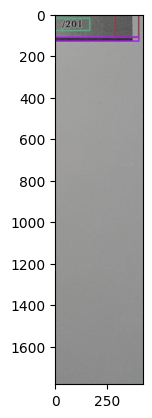

In [ ]:
original_img = cv2.imread('/content/1.jpg', cv2.IMREAD_COLOR)
run(original_img)


# image preprocessing

In [ ]:
def preprocessing(img):
  img_size = 224
  image_array = cv2.imread(img, cv2.IMREAD_COLOR)
  # get the width and height of image
  width, height = Image.open(img).size
  # to check if all image could resize
  try:
    resized_img = cv2.resize(image_array, (img_size, img_size))
  except:
    print('check size!')
  x = np.array(resized_img) / 255
  x = x.reshape(-1, img_size, img_size, 3)
  return x

## predict each image separately

In [ ]:
for images in natsorted(os.listdir('/content/Words')):
  print(images)
  image = preprocessing(f'/content/Words/{images}')

  cv2.imwrite(f"/content/Word_{i}.jpg", image)
  i+=1

  pred=model.predict(image)
  softmax = tf.nn.softmax(pred)
  predictions = np.argmax(pred, axis=-1)
  prediction_num = predictions[0]

  print(softmax.numpy()[0][prediction_num])
  print(classes[predictions[0]])

Word_0.jpg
1/1 [==============================] - 0s 76ms/step
0.31179097
panadol
Word_1.jpg
1/1 [==============================] - 0s 85ms/step
0.3117764
cataflam
Word_2.jpg
1/1 [==============================] - 0s 79ms/step
0.31168386
brufen
Word_3.jpg
1/1 [==============================] - 0s 95ms/step
0.31179014
Diclac
Word_4.jpg
1/1 [==============================] - 0s 63ms/step
0.3116029
panadol
Word_5.jpg
1/1 [==============================] - 0s 43ms/step
0.31175864
brufen
Word_6.jpg
1/1 [==============================] - 0s 69ms/step
0.3117741
panadol
Word_7.jpg
1/1 [==============================] - 0s 69ms/step
0.3117908
panadol
Word_8.jpg
1/1 [==============================] - 0s 60ms/step
0.31052
Actos
Word_9.jpg
1/1 [==============================] - 0s 36ms/step
0.31179097
Diclac
